<a href="https://colab.research.google.com/github/ang-bill/IU-DLMDSME01-Credit-Card-Fraud-Detection/blob/main/Task1_Credit_Card_Fraud_Detection_Classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2. Classifier 1

## Section 2A. Retrieve Dataset from Kaggle Hub
At the first run, the dataset is downloaded from Kaggle and stored locally. Subsequent runs check whether the file already exists.
See: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


In [1]:
import os
import pandas as pd # Pandas dataframe
import kagglehub # Kagglehub to access dataset
import shutil # Util for copying files
from google.colab import drive # Import Google Drive utilities

# Mount Google Drive for persistent storage
drive.mount('/content/drive')
local_storage_base_dir = "/content/drive/MyDrive"

# Dataset details
kaggle_dataset_id = "Colab_Kaggle_Data/mlg-ulb/creditcardfraud"
file_name_in_dataset = "creditcard.csv"

# Construct the full path to locally stored dataset
local_dataset_dir = os.path.join(local_storage_base_dir, *kaggle_dataset_id.split('/'))
full_local_file_path = os.path.join(local_dataset_dir, file_name_in_dataset)

# Ensure the desired local storage directory exists
os.makedirs(local_dataset_dir, exist_ok=True)

df = None # Initialize pandas df

# Check if the file already exists in local storage, otherwise download from Kaggle
if os.path.exists(full_local_file_path):
    print(f"'{file_name_in_dataset}' found locally at '{full_local_file_path}'. Loading from there.")
else:
    print(f"'{file_name_in_dataset}' not found locally. Attempting to download from KaggleHub and store it.")

    # Use kagglehub.dataset_download to get the dataset.
    downloaded_source_root = kagglehub.dataset_download(kaggle_dataset_id)

    # Construct the path to the file within the KaggleHub download location
    source_file_path = os.path.join(downloaded_source_root, file_name_in_dataset)

    if os.path.exists(source_file_path):
        print(f"Dataset found at KaggleHub resolved location: '{source_file_path}'.")
        print(f"Copying '{file_name_in_dataset}' to local path: '{full_local_file_path}'.")

        # Copy the file to local storage location
        shutil.copy(source_file_path, full_local_file_path)

    else:
        raise FileNotFoundError(f"Failed to find '{file_name_in_dataset}' at source '{source_file_path}' after KaggleHub download resolution.")

# Load the dataset into a pandas dataframe
df = pd.read_csv(full_local_file_path)


Mounted at /content/drive
'creditcard.csv' found locally at '/content/drive/MyDrive/Colab_Kaggle_Data/mlg-ulb/creditcardfraud/creditcard.csv'. Loading from there.


## Section 2B. Implementation of utility functions and classes

### 1. Install dependencies
(not included in default Colab Notebook)

In [2]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 13.0 MB/s eta 0:00:00


### 2. Customised Class on Feature Engineering

#### HourExtractor

In [3]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class HourExtractor(BaseEstimator, TransformerMixin):
    """Extracts 'Hour' from 'Time' feature to capture diurnal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Convert seconds to hour of day (0-23)
        X_copy['Hour'] = (X_copy['Time'] % (60*60*24)) // (60*60)

        #return X_copy.drop(columns=['Time']) # Replace Time with Hour
        return X_copy

#### DayNightExtractor

In [4]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DayNightExtractor(BaseEstimator, TransformerMixin):
    """Extracts 'Is_Night' from 'Time' feature to capture diurnal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Convert seconds to hour of day (0-23)
        #X_copy['Hour'] = (X_copy['Time'] % (60*60*24)) // (60*60)

        # Is_Night (Binary): 1 if between 24:00 and 08:00 (convert to hours first)
        X_copy['Is_Night'] = (((X_copy['Time'] % (60*60*24)) // (60*60)) <= 8)
        X_copy['Is_Night'] = X_copy['Is_Night'].astype(int)

        return X_copy

#### LogAmountExtractor

In [5]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LogAmountExtractor(BaseEstimator, TransformerMixin):
    """Extracts Log Amount from Amount to handle the extreme skew
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Log Amount: Handles the extreme skew of transaction amounts
        # np.log1p avoids log(0) errors
        X_copy['Log_Amount'] = np.log1p(X_copy['Amount'])

        return X_copy

#### V14V17InteractionExtractor

In [6]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class V14V17InteractionExtractor(BaseEstimator, TransformerMixin):
    """Extracts a combined feature from V14 and V17 to capture diagonal patterns
    and creates a new feature."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        X_copy['V14_V17'] = X_copy['V14'] * X_copy['V17']

        return X_copy

### 3. Customised Class on Probability Calibration
A customised classifier applies analytical probability calibration according to Dal Pozzolo et al. (2025). This approach enables integration with the scikit-learn library.

https://doi.org/10.1109/SSCI.2015.33

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
import numpy as np

class PozzoloCalibratedClassifier(BaseEstimator, ClassifierMixin):
    """
    Wraps a classifier to apply Dal Pozzolo's prior correction automatically
    during prediction.

    Parameters
    ----------
    estimator : object
        The base classifier (e.g., LogisticRegression or XGBClassifier).
    original_prior : float
        The prevalence of the positive class in the original dataset (e.g., 0.00172).
    sampling_ratio : float, default=1.0
        The target ratio used in RandomUnderSampler (1.0 means 50/50).
    """

    _estimator_type = "classifier"

    def __init__(self, estimator, original_prior=0.00172, sampling_ratio=1.0):
        self.estimator = estimator
        self.original_prior = original_prior
        self.sampling_ratio = sampling_ratio

    def fit(self, X, y):
        # Fit the internal model on the data provided (which is already RUS-sampled)
        self.estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        check_is_fitted(self.estimator)

        # 1. Get Biased Probabilities (P_s) from the internal model
        # The model thinks the world is 50% fraud because of RUS
        probs_biased = self.estimator.predict_proba(X)

        # If we only have 1 class in test (edge case), return as is
        if probs_biased.shape[1] != 2:
            return probs_biased

        p_s = probs_biased[:, 1]

        # 2. Calculate Correction Factor (Gamma)
        # Gamma = (Original_Odds) / (Sampled_Odds)
        # Sampled_Odds for ratio 1.0 is 0.5/0.5 = 1
        prior_s = self.sampling_ratio / (1 + self.sampling_ratio) # e.g. 0.5

        # Edge case protection
        if self.original_prior <= 0 or self.original_prior >= 1:
            return probs_biased

        gamma = (self.original_prior / (1 - self.original_prior)) / \
                (prior_s / (1 - prior_s))

        # 3. Apply Formula
        p_calib = (gamma * p_s) / (gamma * p_s + (1 - p_s))

        # Return in Scikit-Learn format [P(0), P(1)]
        return np.vstack([1 - p_calib, p_calib]).T

    def predict(self, X):
        # This is the Key: predict() now uses the CALIBRATED probability
        # So F2 Score optimization sees the real-world performance
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

    def get_params(self, deep=True):
        # Necessary for RandomizedSearchCV to access the inner 'estimator' params
        params = super().get_params(deep)
        if deep and hasattr(self.estimator, 'get_params'):
            for key, value in self.estimator.get_params().items():
                params[f'estimator__{key}'] = value
        return params

### 3. Customised Class TOS Generator for XGBOD

In [8]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.base import BaseEstimator, TransformerMixin

class TOSGenerator(BaseEstimator, TransformerMixin):
    """
    Generates Transformed Outlier Scores (TOS) for XGBOD.
    Wraps PyOD unsupervised detectors to act as feature extractors.
    """
    def __init__(self, detectors=None):
        self.detectors = detectors

    def fit(self, X, y=None):
        # If no detectors provided, initialize default ones
        # Note: We initialize here to ensure fresh models for every fold
        if self.detectors is None:
            self.detectors = [KNN(n_neighbors=5), LOF(n_neighbors=5)]

        for detector in self.detectors:
            detector.fit(X)
        return self

    def transform(self, X):
        tos_features = []
        for detector in self.detectors:
            # For PyOD, decision_function returns the anomaly score
            # Reshape to (n_samples, 1)
            scores = detector.decision_function(X).reshape(-1, 1)
            tos_features.append(scores)

        # Stack original features with new TOS features
        return np.hstack([X] + tos_features)

### Utility function - Find optimal threshold

In [9]:
def find_optimal_threshold(y, y_proba):
  """
  Find optimal threshold on precicion-recall curve.
  """
  if len(np.unique(y)) == 2:
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_proba)

    # Compute F1 for all thresholds
    numerator = 2 * precision * recall
    denominator = precision + recall
    fscores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

    # Find max F1 index
    ix = np.argmax(fscores)

    # Get the threshold corresponding to max F1
    if ix < len(thresholds):
        return thresholds[ix]
    else:
        return 0.5 # Fallback



### Precision - Recall - AUPRC

In [44]:
# Visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curves_with_std(plotting_data, title="Precision-Recall Curve", save_path=None):
    """
    Plots the Mean Precision-Recall Curve with Standard Deviation shading.
    """
    plt.figure(figsize=(10, 8))

    # Iterate over each configuration (e.g., "Naive", "XGBoost + RUS", etc.)
    for name, data in plotting_data.items():
        y_real_folds = data['y_real']
        y_proba_folds = data['y_proba']

        # Interpolate precision at these fixed recall points
        mean_recall = np.linspace(0, 1, 100)
        precisions = []

        # Process every fold
        for y_true, y_scores in zip(y_real_folds, y_proba_folds):
            # Calculate PR curve for this fold
            precision, recall, _ = precision_recall_curve(y_true, y_scores)

            # Interpolate precision to match the fixed mean_recall grid
            # Note: PR curve is usually plotted Recall (x) vs Precision (y)
            # We reverse arguments for interp because recall is decreasing in the raw output
            interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interp_precision)

        # Convert to array for stats
        precisions = np.array(precisions)

        # Calculate Mean and SD
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Calculate Mean AUC (Area Under Curve) - Average Precision
        mean_auc = auc(mean_recall, mean_precision)

        # --- PLOTTING ---
        p = plt.plot(mean_recall, mean_precision,
                     label=f"{name} (AUC = {mean_auc:.3f})",
                     linewidth=2, alpha=0.9)

        # Add Shading for Standard Deviation (Robustness)
        plt.fill_between(mean_recall,
                         np.maximum(mean_precision - std_precision, 0),
                         np.minimum(mean_precision + std_precision, 1),
                         color=p[0].get_color(), alpha=0.15)

    # Decoration
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    #plt.legend(bbox_to_anchor=(0.5, 0.15), loc='upper center', ncol= 2, fontsize=10)
    #plt.legend(bbox_to_anchor=(0.5, 0.15), loc='lower center', ncol= 2, fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])

    # Add baseline (No Skill)
    # Fraud Ratio ~ 0.0017
    no_skill = 0.00172
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label='No Skill (Baseline)')

    #plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}\n")

    plt.show()

### 9. Confusion matrix

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import textwrap

def plot_confusion_matrices(plot_data, title="Confusion Matrices", save_path=None):
    """
    Plots a grid of Confusion Matrices for each configuration in plot_data.
    Assumes threshold = 0.5 for converting probabilities to labels.
    """
    n_configs = len(plot_data)
    cols = 3
    rows = math.ceil(n_configs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(8, 2.5 * rows))
    axes = axes.flatten()

    # Iterate over each configuration (e.g., "Naive", "XGBoost + RUS", etc.)
    #for name, data in plotting_data.items():
    #    y_real_folds = data['y_real']
    #    y_proba_folds = data['y_proba']

    for idx, (config_name, data) in enumerate(plot_data.items()):
        ax = axes[idx]

        # Extract data (concatenated across folds)
        y_true = np.concatenate(data['y_real'])
        y_proba = np.concatenate(data['y_proba'])

        # Convert probabilities to hard predictions (Threshold 0.5)
        # Note: In a real deployment, you might tune this threshold.
        y_pred = (np.array(y_proba) > 0.5).astype(int)

        # Calculate Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)

        # Calculate percentages for clearer imbalanced view
        #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create labels for each cell
        # Format: Count\n(Percent of True Class)
        #labels = [f"{value}\n({pct:.1%})" for value, pct in zip(cm.flatten(), cm_norm.flatten())]
        labels = [f"{value}" for value in cm.flatten()]
        labels = np.asarray(labels).reshape(2, 2)

        # Plot Heatmap
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax,
                    xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])

        #ax.set_title(f"{config_name}\n(F1: {data.get('mean_f1', 'N/A'):.4f})")
        f1_val = data.get('mean_f1', None)
        wrapped_name = "\n".join(textwrap.wrap(config_name, width=30))

        if isinstance(f1_val, (int, float)):
            # If it's a number, format it nicely
            ax.set_title(f"{wrapped_name}\n(F1: {f1_val:.4f})", fontsize=10)
        else:
            # If it's missing or text, just print the name
            ax.set_title(f"{wrapped_name}", fontsize=10)

        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    # Turn off empty subplots if any
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout(h_pad=3, w_pad=4)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion Matrix plot saved to: {save_path}")

    plt.show()

### Output Hyperparameters

In [12]:
def print_param_grid(params):
    print("--- Hyperparameters ---")
    for key, val in params.items():
        # Check if the value is a Scipy distribution (has 'dist' attribute)
        if hasattr(val, 'dist'):
            dist_name = val.dist.name
            args = val.args

            # Format based on distribution type
            if dist_name == 'randint':
                # args = (low, high)
                val_str = f"randint range [{args[0]}, {args[1]})"
            elif dist_name == 'uniform':
                # args = (loc, scale) -> Range is [loc, loc + scale]
                val_str = f"uniform range [{args[0]}, {args[0] + args[1]}]"
            elif dist_name == 'reciprocal': # This is how loguniform appears internally
                # args = (a, b)
                val_str = f"loguniform range [{args[0]}, {args[1]}]"
            else:
                val_str = f"{dist_name}{args}"
        else:
            # It's a standard list or fixed value
            val_str = str(val)

        print(f"{key:<20} : {val_str}")


### Viszualize and store experiment result to file

In [32]:
import os
import sys
from datetime import datetime
from contextlib import redirect_stdout

def visualize_results(exp_name, params, df_results, plot_data):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"\n=== Ablation Study Results: {exp_name} ===\n")
    print(f"Date: {timestamp}\n")
    #print("--- Hyperparameters ---\n")
    print_param_grid(params)
    print("\n--- Metrics ---\n")
    print(df_results.to_markdown(index=False))

    # e.g., "experiments/20251211_204500_XGBoost_V5_NoRUS_report.txt"
    report_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_report.txt")
    plot_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_plot.png")
    cm_plot_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_ConfMatrix.png")

    with open(report_file, "w") as f:
        f.write(f"=== Ablation Study Results: {exp_name} ===\n")
        f.write(f"Date: {timestamp}\n\n")

        f.write("--- Hyperparameters ---\n")
        with redirect_stdout(f):
            print_param_grid(params)

        f.write("\n\n--- Results Table ---\n")
        f.write(df_results.to_markdown(index=False))

    print(f"\nText report saved to: {report_file}\n")

    # Precision Recall AUC
    plot_pr_curves_with_std(plot_data,
                            title=f"Precision Recall AUC: {exp_name} ",
                            save_path=plot_file)

    # Plot Confusion Matrices
    plot_confusion_matrices(
        plot_data,
        title=f"Confusion Matrices ({exp_name})",
        save_path=cm_plot_file
    )

### Ablation Study (Train, Validate, and Test)

In [36]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.preprocessing import RobustScaler
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as ImbPipeline # Supports resampling inside CV
from imblearn.under_sampling import RandomUnderSampler

def run_ablation_study(experiment_name, base_clf, param_dist, X, y, configs, outlier_detection=None):
    """
    Runs the full ablation study for a specific classifier.

    Parameters:
    - experiment_name: String label (e.g., "XGBoost")
    - base_clf: The instantiated classifier object (e.g., XGBClassifier())
    - param_dist: Dictionary for RandomizedSearchCV
    - X, y: Data
    - configs: Dictionary of ablation configurations
    - extra_pipeline_steps: List of (name, transformer) tuples to add before scaling (e.g., TOS)
    """

    # Cross Validation Outer Loop: Repeated Stratified 5-Fold
    #outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    # Cross Validation Inner Loop: Stratified 4-Fold (used inside RandomizedSearchCV)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    results_table = []
    plotting_data = {}

    print(f"--- Starting Experiment: {experiment_name} ---")

    for name, cfg in configs.items():
        print(f"\n{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Running Configuration: {name}")

        fold_metrics = {
                'f1_test': [], 'f1_train': [],
                'f2_test': [], 'f2_train': [],
                'rec_test': [], 'rec_train': [],
                'prec_test': [], 'prec_train': [],
                'thresh': [], 'best_params': []
            }
        plotting_data[name] = {'y_real': [], 'y_proba': []}

        # Outer CV loop (split training and test set)
        for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # --- A. Build Pipeline Steps ---
            steps = []

            # 1. Feature Engineering
            if cfg['fe_1']:
                steps.append(('fe_1', HourExtractor()))
            if cfg['fe_2']:
                steps.append(('fe_2', DayNightExtractor()))
            if cfg['fe_3']:
                steps.append(('fe_3', LogAmountExtractor()))
            if cfg['fe_4']:
                steps.append(('fe_4', V14V17InteractionExtractor()))

            # 1b. Extra Steps (e.g., XGBOD TOS Generator)
            if outlier_detection:
                steps.extend(outlier_detection)

            # 2. Scaling (RobustScaler)
            if cfg['scale']:
                steps.append(('scaler', RobustScaler()))

            # 3. Resampling (RUS)
            # Resampling in the pipeline preventes data leakage
            # Resampling is only applied to the traning fold inside
            # (https://imbalanced-learn.org/stable/common_pitfalls.html)
            if cfg['rus']:
                steps.append(('rus', RandomUnderSampler(sampling_strategy=1.0, random_state=42)))

            # 4. Classifier
            # SciKit-Learn LogisticRegression
            # (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
            # Regularization is applied by default
            # Solver liblinear: supports L1 and L2 regularization
            if cfg['rus']:
                  #base_clf = LogisticRegression(solver='liblinear', random_state=42)
                  #final_clf = PozzoloCalibratedClassifier(
                  #    estimator=base_clf,
                  #    original_prior=original_fraud_rate,
                  #    sampling_ratio=1.0
                  #)
                  # Wrap with Pozzolo Calibration
                  final_clf = PozzoloCalibratedClassifier(
                      estimator=clone(base_clf), # clone base_clf to ensure fresh start
                      original_prior=original_fraud_rate,
                      sampling_ratio=1.0
                  )
            else:
                  #final_clf = LogisticRegression(solver='liblinear', random_state=42)
                  final_clf = clone(base_clf)

            steps.append(('clf', final_clf))

            # Create pipeline from steps
            pipeline = ImbPipeline(steps)

            # --- B. Optimization (Inner Loop) ---
            if cfg['opt']:
                # Inner CV for optimisation
                # (CV uses a fold of the train set for validation)
                # Optimize for F1 Score

                # Define distribution of the tuneable parameters
                # print(clf.get_params()) # Print tunable parameters
                # Naming convention of parameter names: stepname__parameter
                iterations = 50 if cfg['rus'] else 20

                # Adjust param names for wrapper vs standalone
                # If wrapped: clf__estimator__param
                # If standalone: clf__param
                prefix = 'clf__estimator__' if cfg['rus'] else 'clf__'

                # Update param_dist keys to match current pipeline structure
                tuned_params = {f"{prefix}{k}":
                                v for k, v in param_dist.items()}

                search = RandomizedSearchCV(pipeline, tuned_params,
                                            n_iter=iterations,
                                            scoring=make_scorer(f1_score),
                                            #scoring=make_scorer(fbeta_score, beta=2),
                                            cv=inner_cv, n_jobs=-1,
                                            random_state=42)
                search.fit(X_train, y_train)
                model = search.best_estimator_
            else:
                pipeline.fit(X_train, y_train)
                model = pipeline

            # Prediction on test set
            y_pred_test = model.predict(X_test)

            # Store probabilities for visualisation
            y_proba_test = model.predict_proba(X_test)[:, 1] # calibrated probabilities
            y_proba_train = model.predict_proba(X_train)[:, 1]

            # Find optimal threshold (max F1 score) on training data
            best_thresh_train = find_optimal_threshold(y_train, y_proba_train)
            fold_metrics['thresh'].append(best_thresh_train)

            # Apply this threshold to test data
            y_pred_test_tuned = (y_proba_test >= best_thresh_train).astype(int)

            # Prediction also on training set
            # This enables the measurement of the generalization gap between
            # the training and the test accuracy to control overfitting. See
            # https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
            # Test metrics: measures performance on test data (never seen by model)
            # Training metrics: measures performance on training data (all inner
            #                   folds of CV)
            #y_pred_train = model.predict(X_train)
            y_pred_train_tuned = (y_proba_train >= best_thresh_train).astype(int)

            plotting_data[name]['y_real'].append(y_test)
            plotting_data[name]['y_proba'].append(y_proba_test)

            # Record Metrics on test set (using optimal threshold)
            fold_metrics['f1_test'].append(f1_score(y_test, y_pred_test_tuned))
            fold_metrics['f2_test'].append(fbeta_score(y_test, y_pred_test_tuned, beta=2))
            fold_metrics['rec_test'].append(recall_score(y_test, y_pred_test_tuned))
            fold_metrics['prec_test'].append(precision_score(y_test, y_pred_test_tuned, zero_division=0))

            # Record Metrics on training set
            fold_metrics['f1_train'].append(f1_score(y_train, y_pred_train_tuned))
            fold_metrics['f2_train'].append(fbeta_score(y_train, y_pred_train_tuned, beta=2))
            fold_metrics['rec_train'].append(recall_score(y_train, y_pred_train_tuned))
            fold_metrics['prec_train'].append(precision_score(y_train, y_pred_train_tuned, zero_division=0))

            # Record best optimization parameters
            if cfg['opt']:
              fold_metrics['best_params'].append(search.best_params_)
              #params_df = pd.DataFrame(search.best_params_)
              #print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
              print(pd.DataFrame([search.best_params_]).to_markdown(index=False))

        # --- Aggregate results for this configuration ---
        row = {'Configuration': name}
        metrics_map = {
          'f1': 'F1 Score',
          'f2': 'F2 Score',
          'rec': 'Recall',
          'prec': 'Precision'
          }

        for key, label in metrics_map.items():
          test_scores = fold_metrics[f'{key}_test']
          train_scores = fold_metrics[f'{key}_train']

          # Calculate Mean
          test_mean = np.mean(test_scores)
          train_mean = np.mean(train_scores)

          # Calculate SD (standard deviation)
          # A large SD indicates data sensitivity (i.e. low robustness)
          test_std  = np.std(test_scores)
          if test_mean > 0:
              cv_pct = (test_std / test_mean) * 100  # Coefficient of Variation
          else:
              cv_pct = 0.0

          # Calculate Gap (Train - Test)
          # Large gap indicates overfitting (i.e. low generalization)
          gap = train_mean - test_mean
          if test_mean > 0:
            gap_pct = (gap / test_mean) * 100      # Relative Overfitting
          else:
            gap_pct = 0.0

          # Add Columns to Row
          row[f'{label} (Mean)'] = f"{test_mean:.4f}"
          #row[f'{label} (SD)']   = f"{test_std:.4f} ({cv_pct:.1f}%)"
          row[f'{label} (SD)']   = f"{test_std:.4f}"
          row[f'{label} (SD%)']   = f"{cv_pct:.1f}"
          #row[f'{label} (Gap)']  = f"{gap:.4f} ({gap_pct:.1f}%)"
          row[f'{label} (Gap)']   = f"{gap:.4f}"
          row[f'{label} (Gap%)']   = f"{gap_pct:.1f}"

        # Calculate mean and sd for optimal thresholds
        test_mean = np.mean(fold_metrics['thresh'])
        test_std = np.std(fold_metrics['thresh'])
        row[f'Opt Thresh (Mean)'] = f"{test_mean:.4f}"
        row[f'Opt Thresh (SD)']   = f"{test_std:.4f}"

        # Calculate mean and sd for hyperparameters
        params_df = pd.DataFrame(fold_metrics['best_params'])
        numeric_params_df = params_df.select_dtypes(include=[np.number])
        mean_params = numeric_params_df.mean()
        sd_params = numeric_params_df.std(ddof=1) # Use ddof=1 for sample SD

        for param_name in mean_params.index:
            mean_val = mean_params[param_name]
            sd_val = sd_params[param_name]

            base_name = param_name.split('__')[-1] # Extracts 'C' from 'clf__C'

            row[f'{base_name} (Mean)'] = f"{mean_val:.4f}"
            row[f'{base_name} (SD)'] = f"{sd_val:.4f}"

        # 5. Append the complete row to the results table
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        print(pd.DataFrame([row]).to_markdown(index=False))
        results_table.append(row)

    # --- Return result ---
    return pd.DataFrame(results_table), plotting_data

## Section 2C. Initialization

### Basic Init

In [16]:
import warnings
# Supress the specific warning from imblearn pipeline (supress as pipeline works correctly)
warnings.filterwarnings("ignore", category=FutureWarning, module="imblearn.pipeline")
# Suppress the specific feature name warning from sklearn
warnings.filterwarnings("ignore", message="X has feature names, but IsolationForest was fitted without feature names")

# Dataset details
results_dir = "Colab_Results/creditcardfraud"

# Construct the full path to locally stored dataset
local_results_dir = os.path.join(local_storage_base_dir, *results_dir.split('/'))
os.makedirs(local_results_dir, exist_ok=True)

### Configuration of pipelines
The ablation study evaluates the effect of each component separately, therefore distinct pipelines are defined.

**Components:**
*   Feature engineering: Augmentation with Hour vs. no feature engineering
*   Data preprocessing: RobustScaler vs. no scaling
*   Resampling: RUS vs. no resampling
*   Classifier optimisation: Randomised parameter optimisation vs. using default parameters





### Create features and labels

In [17]:
X = df.drop('Class', axis=1)  # features
y = df['Class'] # Labels
original_fraud_rate = np.mean(y)

print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Dataset Shape: {X.shape}, Fraud Ratio: {np.mean(y):.4}")

2025-12-20 19:04:10 Dataset Shape: (284807, 30), Fraud Ratio: 0.001727


In [43]:
# We define distinct pipelines to test each component
configs = {
    "1. Naive (No Preproc)": {
        'scale': False, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'rus': False, 'opt': False
    },
    "2. + Scaling (Robust)": {
        'scale': True, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.1 + Feature Eng (Hour)": {
        'scale': True, 'fe_1': True, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.2 + Feature Eng (DayNight)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.3 + Feature Eng (LogAmount)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': False,  'rus': False, 'opt': False
    },
    "3.4 + Feature Eng (V14-V17-Interaction)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': False, 'opt': False
    },
    "4. + RUS (Calibrated)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': True, 'opt': False
    },
    "5.A Optimization (Scaling + FE + RUS)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': True, 'opt': True
    },
    "5.B Optimization (Scaling + FE)": {
        'scale': True, 'fe_1': True, 'fe_2': True, 'fe_3': True, 'fe_4': True,  'rus': False, 'opt': True
    },
    "5.C Optimization (Scaling + FE (only Hour))": {
        'scale': True, 'fe_1': True, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'rus': False, 'opt': True
    },
    "5.D Optimization (Scaling + FE (only V14-V17-Interaction))": {
        'scale': True, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': True,  'rus': False, 'opt': True
    }
}

In [55]:
test_configs = {
    "2. + Scaling (Robust)": {
        'scale': True, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'rus': False, 'opt': False
    }
}
testopt_configs = {
    "2. + Scaling (Robust) + Opt": {
        'scale': True, 'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'rus': False, 'opt': True
    }
}

## Section 2C. Implementation of Base Classifier - Logistic Regression



=== Ablation Study Results: Baseline Logistic Regression ===

Date: 20251220_230401

--- Hyperparameters ---
C                    : loguniform(0.0001, 1)
penalty              : ['l1', 'l2']

--- Metrics ---

| Configuration                                              |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   Opt Thresh (Mean) |   Opt Thresh (SD) |   C (Mean) |   C (SD) |
|:-----------------------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|-----------

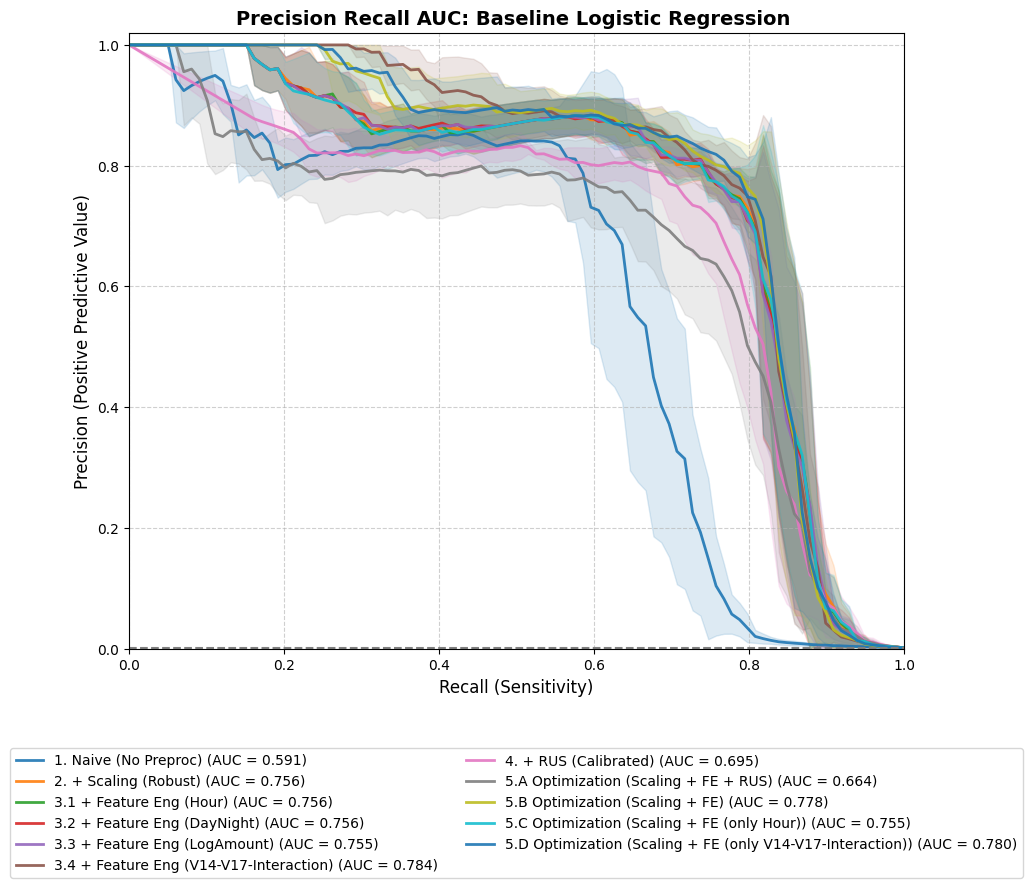

Confusion Matrix plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251220_230401_Baseline Logistic Regression_ConfMatrix.png


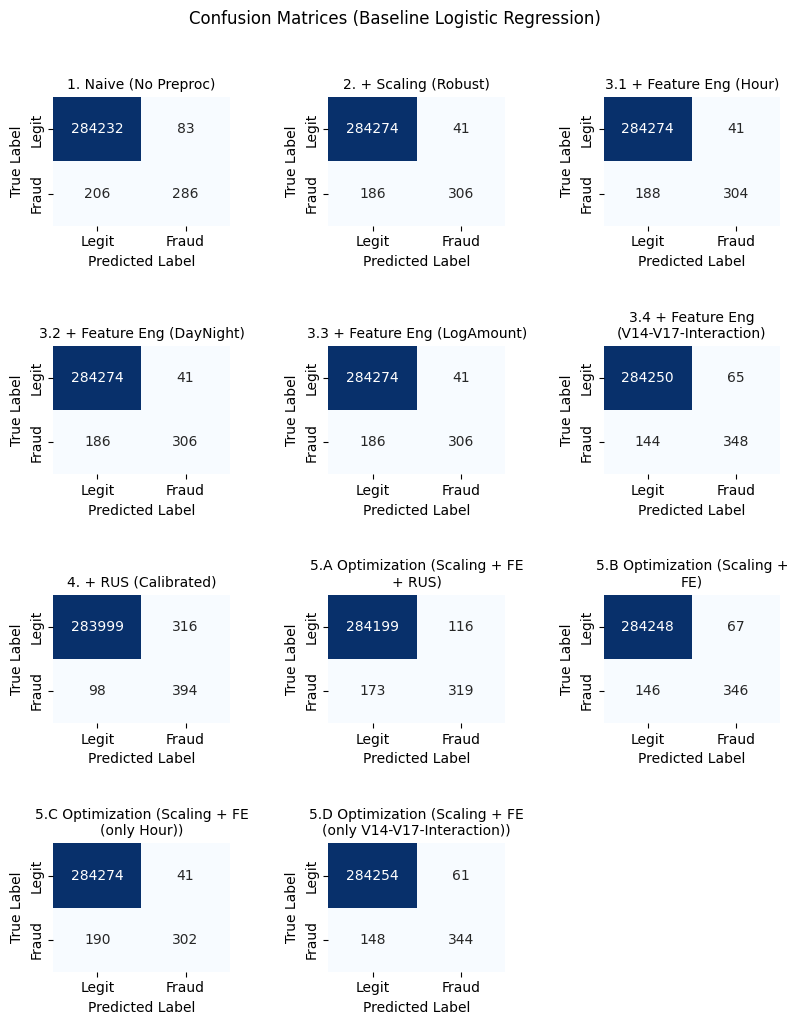

In [82]:
from scipy.stats import uniform, loguniform

lr_params_v1 = {'C': loguniform(1e-4, 1)}
lr_params_v2 = {'C': loguniform(1e-4, 1), # regularization strength
             'l1_ratio': uniform(0, 1) # choose between L1, L2, or mixed regularization
}
lr_params_v3 = {'C': loguniform(1e-4, 1), # regularization strength
             'l1_ratio': [0, 1] # choose between L2 (l1_ratio=0) or L2 (l1_ratio=1) regularization
}
lr_params = {'C': loguniform(1e-4, 1), # regularization strength
             'penalty': ['l1', 'l2']   # regularization type
             }

df_results, plot_data = run_ablation_study(
    experiment_name="Logistic Regression",
    base_clf=LogisticRegression(
        solver='liblinear',
        dual=False,        # Required for L1 (primal form, more samples than features)
        #max_iter=1000,    # default 100
        #solver='saga',
        #penalty='elasticnet',
        #max_iter=500,
        random_state=42),
    param_dist=lr_params,
    X=X, y=y, configs=configs
)

visualize_results("Baseline Logistic Regression", lr_params, df_results, plot_data)


=== Ablation Study Results: Baseline Logistic Regression ===

Date: 20251214_134501

--- Hyperparameters ---
C                    : loguniform(0.0001, 100.0)

--- Metrics ---

| Configuration                               |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   C (Mean) |   C (SD) |
|:--------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|-----------:|---------:|
| 1. Naive (No Preproc)                       |            0.6101 |          0.0708 |             11.6 |           0.0217 |               3.6 |            0.6614 |          0.0504 |              7.6 |           0.0215 |               3.2 |          0.5813 |        0.0815 |           14   |         0.0208 |             3.6 |             0.7806 |           0.045  |               5.8 |            0.0115 |                1.5 |   nan      | nan      |
| 2. + Scaling (Robust)                       |            0.6607 |          0.0378 |              5.7 |           0.006  |               0.9 |            0.729  |          0.0324 |              4.5 |           0.0056 |               0.8 |          0.6221 |        0.0408 |            6.6 |         0.006  |             1   |             0.8827 |           0.0329 |               3.7 |            0.0021 |                0.2 |   nan      | nan      |
| 3.1 + Feature Eng (Hour)                    |            0.657  |          0.0329 |              5   |           0.0098 |               1.5 |            0.7261 |          0.0292 |              4   |           0.0087 |               1.2 |          0.618  |        0.0351 |            5.7 |         0.0101 |             1.6 |             0.8821 |           0.0329 |               3.7 |            0.0033 |                0.4 |   nan      | nan      |
| 3.2 + Feature Eng (DayNight)                |            0.6608 |          0.0326 |              4.9 |           0.0105 |               1.6 |            0.7292 |          0.0287 |              3.9 |           0.0089 |               1.2 |          0.622  |        0.0351 |            5.6 |         0.0111 |             1.8 |             0.8828 |           0.0328 |               3.7 |            0.0022 |                0.2 |   nan      | nan      |
| 3.3 + Feature Eng (LogAmount)               |            0.6608 |          0.0316 |              4.8 |           0.01   |               1.5 |            0.7292 |          0.0286 |              3.9 |           0.0083 |               1.1 |          0.6221 |        0.0336 |            5.4 |         0.0106 |             1.7 |             0.8827 |           0.0334 |               3.8 |            0.0015 |                0.2 |   nan      | nan      |
| 3.4 + Feature Eng (V14-V17-Interaction)     |            0.7306 |          0.0201 |              2.8 |           0.0128 |               1.7 |            0.7692 |          0.0169 |              2.2 |           0.0141 |               1.8 |          0.7073 |        0.0264 |            3.7 |         0.0117 |             1.6 |             0.8455 |           0.042  |               5   |            0.0148 |                1.7 |   nan      | nan      |
| 4. + RUS (Calibrated)                       |            0.7377 |          0.0439 |              5.9 |          -0.0017 |              -0.2 |            0.6662 |          0.0895 |             13.4 |          -0.0067 |              -1   |          0.8008 |        0.0206 |            2.6 |         0.004  |             0.5 |             0.5839 |           0.1427 |              24.4 |           -0.0107 |               -1.8 |   nan      | nan      |
| 5.A Optimization (Scaling + FE + RUS)       |            0.7339 |          0.044  |              6   |          -0.0007 |              -0.1 |            0.6829 |          0.0841 |             12.3 |          -0.0049 |              -0.7 |          0.7764 |        0.0144 |            1.9 |         0.0031 |             0.4 |             0.6207 |           0.1358 |              21.9 |           -0.0091 |               -1.5 |     0.3562 |   0.103  |
| 5.B Optimization (Scaling + FE)             |            0.7313 |          0.0194 |              2.7 |           0.0154 |               2.1 |            0.771  |          0.0185 |              2.4 |           0.0161 |               2.1 |          0.7074 |        0.0246 |            3.5 |         0.0147 |             2.1 |             0.8496 |           0.0434 |               5.1 |            0.0155 |                1.8 |     0.982  |   1.0713 |
| 5.C Optimization (Scaling + FE (only Hour)) |            0.6552 |          0.0329 |              5   |           0.0117 |               1.8 |            0.7246 |          0.0298 |              4.1 |           0.0104 |               1.4 |          0.616  |        0.0349 |            5.7 |         0.0121 |             2   |             0.8816 |           0.0335 |               3.8 |            0.0045 |                0.5 |    11.127  |  22.0931 |

Text report saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251214_134501_Baseline Logistic Regression_report.txt


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251214_134501_Baseline Logistic Regression_plot.png

2025-12-11 Config version 4, 1 repeat

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc)                   |            0.6101 |          0.0708 |             11.6 |           0.0217 |               3.6 |            0.6614 |          0.0504 |              7.6 |           0.0215 |               3.2 |          0.5813 |        0.0815 |           14   |         0.0208 |             3.6 |             0.7806 |           0.045  |               5.8 |            0.0115 |                1.5 |
| 2. + Scaling (Robust)                   |            0.6607 |          0.0378 |              5.7 |           0.006  |               0.9 |            0.729  |          0.0324 |              4.5 |           0.0056 |               0.8 |          0.6221 |        0.0408 |            6.6 |         0.006  |             1   |             0.8827 |           0.0329 |               3.7 |            0.0021 |                0.2 |
| 3.A + Feature Eng (Hour)                |            0.657  |          0.0329 |              5   |           0.0098 |               1.5 |            0.7261 |          0.0292 |              4   |           0.0087 |               1.2 |          0.618  |        0.0351 |            5.7 |         0.0101 |             1.6 |             0.8821 |           0.0329 |               3.7 |            0.0033 |                0.4 |
| 3.A + Feature Eng (DayNight)            |            0.6608 |          0.0326 |              4.9 |           0.0105 |               1.6 |            0.7292 |          0.0287 |              3.9 |           0.0089 |               1.2 |          0.622  |        0.0351 |            5.6 |         0.0111 |             1.8 |             0.8828 |           0.0328 |               3.7 |            0.0022 |                0.2 |
| 3.A + Feature Eng (LogAmount)           |            0.6608 |          0.0316 |              4.8 |           0.01   |               1.5 |            0.7292 |          0.0286 |              3.9 |           0.0083 |               1.1 |          0.6221 |        0.0336 |            5.4 |         0.0106 |             1.7 |             0.8827 |           0.0334 |               3.8 |            0.0015 |                0.2 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 |          0.0201 |              2.8 |           0.0128 |               1.7 |            0.7692 |          0.0169 |              2.2 |           0.0141 |               1.8 |          0.7073 |        0.0264 |            3.7 |         0.0117 |             1.6 |             0.8455 |           0.042  |               5   |            0.0148 |                1.7 |
| 4. + RUS (Calibrated)                   |            0.7377 |          0.0439 |              5.9 |          -0.0017 |              -0.2 |            0.6662 |          0.0895 |             13.4 |          -0.0067 |              -1   |          0.8008 |        0.0206 |            2.6 |         0.004  |             0.5 |             0.5839 |           0.1427 |              24.4 |           -0.0107 |               -1.8 |
| 5. + Optimization (with RUS)            |            0.7339 |          0.044  |              6   |          -0.0007 |              -0.1 |            0.6829 |          0.0841 |             12.3 |          -0.0049 |              -0.7 |          0.7764 |        0.0144 |            1.9 |         0.0031 |             0.4 |             0.6207 |           0.1358 |              21.9 |           -0.0091 |               -1.5 |
| 6. + Optimization (without RUS)         |            0.7289 |          0.0183 |              2.5 |           0.0151 |               2.1 |            0.7679 |          0.0161 |              2.1 |           0.0162 |               2.1 |          0.7053 |        0.0244 |            3.5 |         0.0142 |             2   |             0.8451 |           0.0422 |               5   |            0.0163 |                1.9 |


2025-12-11 Config version 4, 1 repeat

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) | F2 Score (SD)   | F2 Score (Gap)   |   F1 Score (Mean) | F1 Score (SD)   | F1 Score (Gap)   |   Recall (Mean) | Recall (SD)    | Recall (Gap)   |   Precision (Mean) | Precision (SD)   | Precision (Gap)   |
|:----------------------------------------|------------------:|:----------------|:-----------------|------------------:|:----------------|:-----------------|----------------:|:---------------|:---------------|-------------------:|:-----------------|:------------------|
| 1. Naive (No Preproc)                   |            0.6101 | 0.0708 (11.6%)  | 0.0217 (3.6%)    |            0.6614 | 0.0504 (7.6%)   | 0.0215 (3.2%)    |          0.5813 | 0.0815 (14.0%) | 0.0208 (3.6%)  |             0.7806 | 0.0450 (5.8%)    | 0.0115 (1.5%)     |
| 2. + Scaling (Robust)                   |            0.6607 | 0.0378 (5.7%)   | 0.0060 (0.9%)    |            0.729  | 0.0324 (4.5%)   | 0.0056 (0.8%)    |          0.6221 | 0.0408 (6.6%)  | 0.0060 (1.0%)  |             0.8827 | 0.0329 (3.7%)    | 0.0021 (0.2%)     |
| 3.A + Feature Eng (Hour)                |            0.657  | 0.0329 (5.0%)   | 0.0098 (1.5%)    |            0.7261 | 0.0292 (4.0%)   | 0.0087 (1.2%)    |          0.618  | 0.0351 (5.7%)  | 0.0101 (1.6%)  |             0.8821 | 0.0329 (3.7%)    | 0.0033 (0.4%)     |
| 3.A + Feature Eng (DayNight)            |            0.6608 | 0.0326 (4.9%)   | 0.0105 (1.6%)    |            0.7292 | 0.0287 (3.9%)   | 0.0089 (1.2%)    |          0.622  | 0.0351 (5.6%)  | 0.0111 (1.8%)  |             0.8828 | 0.0328 (3.7%)    | 0.0022 (0.2%)     |
| 3.A + Feature Eng (LogAmount)           |            0.6608 | 0.0316 (4.8%)   | 0.0100 (1.5%)    |            0.7292 | 0.0286 (3.9%)   | 0.0083 (1.1%)    |          0.6221 | 0.0336 (5.4%)  | 0.0106 (1.7%)  |             0.8827 | 0.0334 (3.8%)    | 0.0015 (0.2%)     |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 | 0.0201 (2.8%)   | 0.0128 (1.7%)    |            0.7692 | 0.0169 (2.2%)   | 0.0141 (1.8%)    |          0.7073 | 0.0264 (3.7%)  | 0.0117 (1.6%)  |             0.8455 | 0.0420 (5.0%)    | 0.0148 (1.7%)     |
| 4. + RUS (Calibrated)                   |            0.7377 | 0.0439 (5.9%)   | -0.0017 (-0.2%)  |            0.6662 | 0.0895 (13.4%)  | -0.0067 (-1.0%)  |          0.8008 | 0.0206 (2.6%)  | 0.0040 (0.5%)  |             0.5839 | 0.1427 (24.4%)   | -0.0107 (-1.8%)   |
| 5. + Optimization (with RUS)            |            0.7339 | 0.0440 (6.0%)   | -0.0007 (-0.1%)  |            0.6829 | 0.0841 (12.3%)  | -0.0049 (-0.7%)  |          0.7764 | 0.0144 (1.9%)  | 0.0031 (0.4%)  |             0.6207 | 0.1358 (21.9%)   | -0.0091 (-1.5%)   |
| 6. + Optimization (without RUS)         |            0.7289 | 0.0183 (2.5%)   | 0.0151 (2.1%)    |            0.7679 | 0.0161 (2.1%)   | 0.0162 (2.1%)    |          0.7053 | 0.0244 (3.5%)  | 0.0142 (2.0%)  |             0.8451 | 0.0422 (5.0%)    | 0.0163 (1.9%)     |

2025-11-09 (5 repeat):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.6195 |          0.0538 |            0.6599 |          0.0434 |             0.5959 |           0.0615 |                0.7465 |              0.0574 |
| 2. + Scaling (Robust)                   |            0.6569 |          0.0464 |            0.7238 |          0.0364 |             0.6191 |           0.0516 |                0.8756 |              0.0299 |
| 3.A + Feature Eng (Hour)                |            0.6576 |          0.0444 |            0.7249 |          0.0344 |             0.6195 |           0.0496 |                0.8778 |              0.0297 |
| 3.A + Feature Eng (DayNight)            |            0.6561 |          0.0455 |            0.7228 |          0.0369 |             0.6183 |           0.05   |                0.8738 |              0.0317 |
| 3.A + Feature Eng (LogAmount)           |            0.6599 |          0.046  |            0.7268 |          0.038  |             0.622  |           0.0501 |                0.8778 |              0.0329 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.734  |          0.0326 |            0.7718 |          0.027  |             0.711  |           0.0378 |                0.8463 |              0.0382 |


2025-11-09 (only 1 repeat):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.6101 |          0.0708 |            0.6614 |          0.0504 |             0.5813 |           0.0815 |                0.7806 |              0.045  |
| 2. + Scaling (Robust)                   |            0.6607 |          0.0378 |            0.729  |          0.0324 |             0.6221 |           0.0408 |                0.8827 |              0.0329 |
| 3.A + Feature Eng (Hour)                |            0.657  |          0.0329 |            0.7261 |          0.0292 |             0.618  |           0.0351 |                0.8821 |              0.0329 |
| 3.A + Feature Eng (DayNight)            |            0.6608 |          0.0326 |            0.7292 |          0.0287 |             0.622  |           0.0351 |                0.8828 |              0.0328 |
| 3.A + Feature Eng (LogAmount)           |            0.6608 |          0.0316 |            0.7292 |          0.0286 |             0.6221 |           0.0336 |                0.8827 |              0.0334 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7306 |          0.0201 |            0.7692 |          0.0169 |             0.7073 |           0.0264 |                0.8455 |              0.042  |

2025-11-06 with PozzoloCalibratedClassifier (after code changes):

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |   Best Params (Mean) |   Best Params (SD) |
|:-------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|---------------------:|-------------------:|
| 1. Naive (No Preproc)    |            0.6195 |          0.0538 |            0.6599 |          0.0434 |             0.5959 |           0.0615 |                0.7465 |              0.0574 |             nan      |           nan      |
| 2. + Scaling (Robust)    |            0.6569 |          0.0464 |            0.7238 |          0.0364 |             0.6191 |           0.0516 |                0.8756 |              0.0299 |             nan      |           nan      |
| 3. + Feature Eng (Hour)  |            0.6576 |          0.0444 |            0.7249 |          0.0344 |             0.6195 |           0.0496 |                0.8778 |              0.0297 |             nan      |           nan      |
| 4. + RUS (Calibrated)    |            0.6978 |          0.0669 |            0.5995 |          0.1059 |             0.7967 |           0.0586 |                0.4988 |              0.1465 |             nan      |           nan      |
| 5. + Optimization (Full) |            0.7008 |          0.0582 |            0.6215 |          0.0894 |             0.774  |           0.0573 |                0.5343 |              0.1329 |               0.5219 |             0.2571 |


2025-11-06 with PozzoloCalibratedClassifier :

=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            | F2 Score (Mean ± SD)   |   F1 Score |   Recall |   Precision |
|:-------------------------|:-----------------------|-----------:|---------:|------------:|
| 1. Naive (No Preproc)    | 0.6195 ± 0.0538        |     0.6599 |   0.5959 |      0.7465 |
| 2. + Scaling (Robust)    | 0.6569 ± 0.0464        |     0.7238 |   0.6191 |      0.8756 |
| 3. + Feature Eng (Hour)  | 0.6576 ± 0.0444        |     0.7249 |   0.6195 |      0.8778 |
| 4. + RUS (Calibrated)    | 0.6978 ± 0.0669        |     0.5995 |   0.7967 |      0.4988 |
| 5. + Optimization (Full) | 0.7008 ± 0.0582        |     0.6215 |   0.774  |      0.5343 |


2025-11-06 without PozzoloCalibratedClassifier:


```
Dataset Shape: (284807, 30), Fraud Ratio: 0.1727%
Starting Ablation Study (this may take a moment)...
Running Configuration: 1. Naive (No Preproc)
Running Configuration: 2. + Scaling (Robust)
Running Configuration: 3. + Feature Eng (Hour)
Running Configuration: 4. + RUS (Calibrated)
Running Configuration: 5. + Optimization (Full)
```


=== Ablation Study Results (Baseline: Logistic Regression) ===
| Configuration            | F2 Score (Mean ± SD)   |   F1 Score |   Recall |   Precision |
|:-------------------------|:-----------------------|-----------:|---------:|------------:|
| 1. Naive (No Preproc)    | 0.6195 ± 0.0538        |     0.6599 |   0.5959 |      0.7465 |
| 2. + Scaling (Robust)    | 0.6569 ± 0.0464        |     0.7238 |   0.6191 |      0.8756 |
| 3. + Feature Eng (Hour)  | 0.6576 ± 0.0444        |     0.7249 |   0.6195 |      0.8778 |
| 4. + RUS (Calibrated)    | 0.6978 ± 0.0669        |     0.5995 |   0.7967 |      0.4988 |
| 5. + Optimization (Full) | 0.6052 ± 0.0515        |     0.6251 |   0.5946 |      0.6721 |

## Section 2D. Implementation of Classifier 1 - XGBoost


--- Starting Experiment: XGBoost ---

2025-12-14 13:13:07 Running Configuration: 1. Naive (No Preproc)
2025-12-14 13:13:27

| Configuration         |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc) |            0.7925 |          0.0279 |   

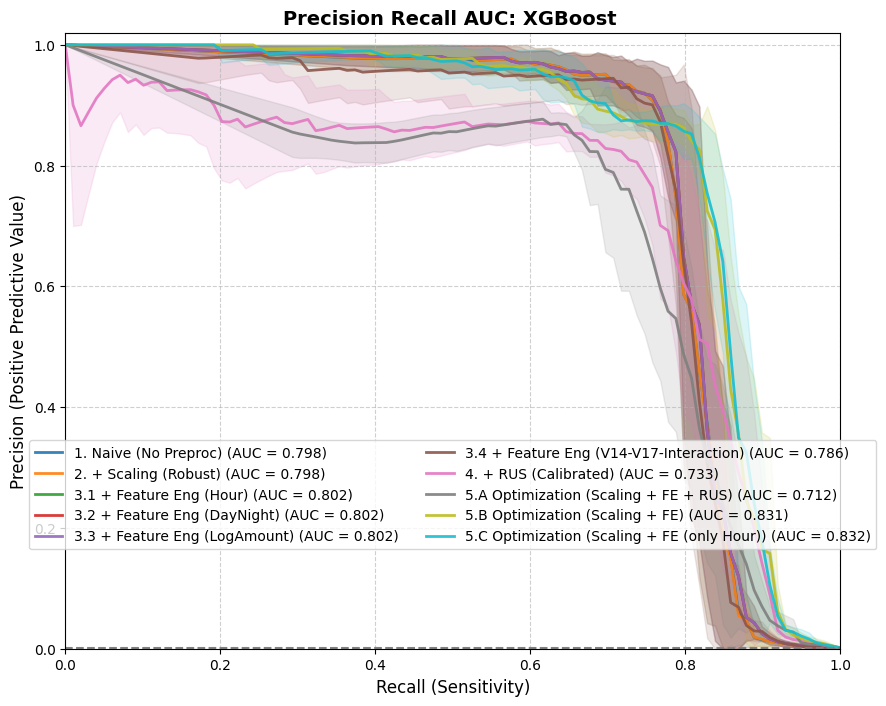

In [ ]:
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier

# XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

# Params version 1
xgb_params_v1 = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': loguniform(0.01, 0.3)
}

# Params version 2
xgb_params_v2 = {
    'scale_pos_weight': randint(10, 101),  # Range: 10 - 100
    'max_depth': randint(3, 7),  # Range: 3 - 6 (randint upper bound is exclusive)
    'learning_rate': loguniform(0.01, 0.1),  # Range: 0.01 - 0.1
    'n_estimators': [100, 200],
    'min_child_weight': randint(5, 11),    # Range: 5 - 10
    'gamma': uniform(0.1, 0.4),            # Range: 0.1 - 0.5 (loc=0.1, scale=0.4)
    'subsample': uniform(0.6, 0.3),        # Range: 0.6 - 0.9 (loc=0.6, scale=0.3)
    'colsample_bytree': uniform(0.6, 0.3)  # Range: 0.6 - 0.9 (loc=0.6, scale=0.3)
}

# Params version 3
xgb_params_v3 = {
    'scale_pos_weight': randint(10, 101),  # Range: 10 - 100
    'max_depth': randint(3, 7),  # Range: 3 - 6 (randint upper bound is exclusive)
    'learning_rate': loguniform(0.01, 0.1),  # Range: 0.01 - 0.1

    'n_estimators': [150],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Params version 4
xgb_params_v4 = {
    'scale_pos_weight': randint(10, 1000),  # Range including legit/fraud ratio 578:1
    'max_depth': randint(3, 8), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),  # default 0.3, Step size shrinkage used in update to prevent overfitting.

    'n_estimators': [150],
    #'min_child_weight': [5], # default 1, the larger, the more conservative
    #'gamma': [0.1], # default 0, Minimum loss reduction required to make a
                    # further partition on a leaf node of the tree. The larger
                    # gamma is, the more conservative the algorithm will be.
    #'subsample': [0.8], # default 1
    #'colsample_bytree': [0.8] # default 1
}

# Params version 5
# More regularization than v4
xgb_params_v5 = {
    'scale_pos_weight': randint(10, 600),  # Range including legit/fraud ratio 578:1
    'max_depth': randint(3, 6), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more
                                # likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),
                                # default 0.3, Step size shrinkage used in
                                # update to prevent overfitting.
    'min_child_weight': [5, 15], # default 1, the larger, the more conservative

    'n_estimators': [150],

    # Set minimum loss reduction for regularization
    'gamma': [0.2],  # default 0, Minimum loss reduction required
                    # to make a further partition on a leaf node of the tree.
                    # The larger gamma is, the more conservative the algorithm
                    # will be.

    # Train each tree only on 70% of data / columns to prevent overvitting
    'subsample': [0.7], # default 1, subsample ratio of the training instances
                        # (per boosting iteration)
    'colsample_bytree': [0.7] # default 1, subsample ratio of columns when
                              # constructing each tree.
}

# Params version 6
# Refinement of v5: increase the range of min_child_weight and increase the lower bound of scale_pos_weight.
xgb_params_v6 = {
    'scale_pos_weight': randint(300, 600),  # Range including legit/fraud ratio 578:1
    'max_depth': randint(3, 6), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more
                                # likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),
                                # default 0.3, Step size shrinkage used in
                                # update to prevent overfitting.
    'min_child_weight': [5, 20], # default 1, the larger, the more conservative

    'n_estimators': [150],

    # Set minimum loss reduction for regularization
    'gamma': [0.2],  # default 0, Minimum loss reduction required
                    # to make a further partition on a leaf node of the tree.
                    # The larger gamma is, the more conservative the algorithm
                    # will be.

    # Train each tree only on 70% of data / columns to prevent overvitting
    'subsample': [0.7], # default 1, subsample ratio of the training instances
                        # (per boosting iteration)
    'colsample_bytree': [0.7] # default 1, subsample ratio of columns when
                              # constructing each tree.
}

# Params version 7
# Refinement of v6: increase the lower bound of min_child_weight to prevent overfit and set to randint, increase lower bound of scale_pos_weight
xgb_params_v7 = {
    'scale_pos_weight': randint(400, 600),  # Range including legit/fraud ratio 578:1
    'max_depth': randint(3, 6), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more
                                # likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),
                                # default 0.3, Step size shrinkage used in
                                # update to prevent overfitting.
    'min_child_weight': randint(20, 50), # default 1, the larger, the more conservative

    'n_estimators': [150],

    # Set minimum loss reduction for regularization
    'gamma': [0.2],  # default 0, Minimum loss reduction required
                    # to make a further partition on a leaf node of the tree.
                    # The larger gamma is, the more conservative the algorithm
                    # will be.

    # Train each tree only on 70% of data / columns to prevent overvitting
    'subsample': [0.7], # default 1, subsample ratio of the training instances
                        # (per boosting iteration)
    'colsample_bytree': [0.7] # default 1, subsample ratio of columns when
                              # constructing each tree.
}
xgb_params = xgb_params_v7


xgb_df_results, xgb_plot_data = run_ablation_study(
    experiment_name="XGBoost",
    base_clf=XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1),
      # eval_metric='logloss' - eval metric for learning, logloss (negative log-likelihood, suitable for classification)
    param_dist=xgb_params,
    X=X, y=y, configs=configs
)

visualize_results("XGBoost", xgb_params, xgb_df_results, xgb_plot_data)



2025-12-12 parameters version 7, 1 repeat

=== Ablation Study Results: XGBoost ===

Date: 20251212_132337

--- Hyperparameters ---

```
scale_pos_weight     : randint range [400, 600)
max_depth            : randint range [3, 6)
learning_rate        : loguniform(0.01, 0.1)
min_child_weight     : randint range [20, 50)
n_estimators         : [150]
gamma                : [0.2]
subsample            : [0.7]
colsample_bytree     : [0.7]
```



--- Metrics ---

| Configuration                               |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   colsample_bytree (Mean) |   colsample_bytree (SD) |   gamma (Mean) |   gamma (SD) |   learning_rate (Mean) |   learning_rate (SD) |   max_depth (Mean) |   max_depth (SD) |   min_child_weight (Mean) |   min_child_weight (SD) |   n_estimators (Mean) |   n_estimators (SD) |   scale_pos_weight (Mean) |   scale_pos_weight (SD) |   subsample (Mean) |   subsample (SD) |
|:--------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|--------------------------:|------------------------:|---------------:|-------------:|-----------------------:|---------------------:|-------------------:|-----------------:|--------------------------:|------------------------:|----------------------:|--------------------:|--------------------------:|------------------------:|-------------------:|-----------------:|
| 1. Naive (No Preproc)                       |            0.7925 |          0.0279 |              3.5 |           0.2    |              25.2 |            0.8285 |          0.0282 |              3.4 |           0.1651 |              19.9 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.897  |           0.0386 |               4.3 |            0.0984 |               11   |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 2. + Scaling (Robust)                       |            0.7929 |          0.0284 |              3.6 |           0.1997 |              25.2 |            0.8294 |          0.0293 |              3.5 |           0.1642 |              19.8 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.8991 |           0.0395 |               4.4 |            0.0964 |               10.7 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 3.1 + Feature Eng (Hour)                    |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 3.2 + Feature Eng (DayNight)                |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 3.3 + Feature Eng (LogAmount)               |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 3.4 + Feature Eng (V14-V17-Interaction)     |            0.7934 |          0.0345 |              4.3 |           0.2003 |              25.2 |            0.8312 |          0.0345 |              4.2 |           0.1637 |              19.7 |          0.7703 |        0.0367 |            4.8 |         0.2226 |            28.9 |             0.9043 |           0.0487 |               5.4 |            0.0926 |               10.2 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 4. + RUS (Calibrated)                       |            0.7565 |          0.0533 |              7.1 |           0.0225 |               3   |            0.7238 |          0.0995 |             13.7 |           0.0261 |               3.6 |          0.7865 |        0.0226 |            2.9 |         0.0209 |             2.7 |             0.6871 |           0.1475 |              21.5 |            0.0338 |                4.9 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                 nan     |              nan   |              nan |
| 5.A Optimization (Scaling + FE + RUS)       |            0.6536 |          0.0576 |              8.8 |           0.0033 |               0.5 |            0.5043 |          0.0663 |             13.1 |           0.0007 |               0.1 |          0.819  |        0.0346 |            4.2 |         0.0072 |             0.9 |             0.3667 |           0.0621 |              16.9 |           -0.0007 |               -0.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0333 |               0.0003 |                  3 |                0 |                      37.2 |                  1.6432 |                   150 |                   0 |                     479.6 |                  29.577 |                0.7 |                0 |
| 5.B Optimization (Scaling + FE)             |            0.8036 |          0.02   |              2.5 |           0.1288 |              16   |            0.7483 |          0.0284 |              3.8 |           0.0982 |              13.1 |          0.8455 |        0.0163 |            1.9 |         0.1545 |            18.3 |             0.6719 |           0.0395 |               5.9 |            0.0619 |                9.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0845 |               0      |                  5 |                0 |                      35   |                  0      |                   150 |                   0 |                     414   |                   0     |                0.7 |                0 |
| 5.C Optimization (Scaling + FE (only Hour)) |            0.8115 |          0.0256 |              3.2 |           0.1244 |              15.3 |            0.7611 |          0.0353 |              4.6 |           0.0928 |              12.2 |          0.8496 |        0.0228 |            2.7 |         0.1504 |            17.7 |             0.6907 |           0.0494 |               7.1 |            0.0543 |                7.9 |                       0.7 |                       0 |            0.2 |            0 |                 0.0845 |               0      |                  5 |                0 |                      35   |                  0      |                   150 |                   0 |                     414   |                   0     |                0.7 |                0 |

Text report saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_132337_XGBoost_report.txt


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_132337_XGBoost_plot.png



2025-11-11 (Params version 6, 1 repeat):
Date: 20251212_000043

--- Hyperparameters ---

```
scale_pos_weight     : randint range [300, 600)
max_depth            : randint range [3, 6)
learning_rate        : loguniform(0.01, 0.1)
min_child_weight     : [5, 20]
n_estimators         : [150]
gamma                : [0.2]
subsample            : [0.7]
colsample_bytree     : [0.7]
```



--- Metrics ---

| Configuration                               |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   colsample_bytree (Mean) |   colsample_bytree (SD) |   gamma (Mean) |   gamma (SD) |   learning_rate (Mean) |   learning_rate (SD) |   max_depth (Mean) |   max_depth (SD) |   min_child_weight (Mean) |   min_child_weight (SD) |   n_estimators (Mean) |   n_estimators (SD) |   scale_pos_weight (Mean) |   scale_pos_weight (SD) |   subsample (Mean) |   subsample (SD) |
|:--------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|--------------------------:|------------------------:|---------------:|-------------:|-----------------------:|---------------------:|-------------------:|-----------------:|--------------------------:|------------------------:|----------------------:|--------------------:|--------------------------:|------------------------:|-------------------:|-----------------:|
| 1. Naive (No Preproc)                       |            0.7925 |          0.0279 |              3.5 |           0.2    |              25.2 |            0.8285 |          0.0282 |              3.4 |           0.1651 |              19.9 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.897  |           0.0386 |               4.3 |            0.0984 |               11   |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 2. + Scaling (Robust)                       |            0.7929 |          0.0284 |              3.6 |           0.1997 |              25.2 |            0.8294 |          0.0293 |              3.5 |           0.1642 |              19.8 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.8991 |           0.0395 |               4.4 |            0.0964 |               10.7 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.1 + Feature Eng (Hour)                    |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.2 + Feature Eng (DayNight)                |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.3 + Feature Eng (LogAmount)               |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.4 + Feature Eng (V14-V17-Interaction)     |            0.7934 |          0.0345 |              4.3 |           0.2003 |              25.2 |            0.8312 |          0.0345 |              4.2 |           0.1637 |              19.7 |          0.7703 |        0.0367 |            4.8 |         0.2226 |            28.9 |             0.9043 |           0.0487 |               5.4 |            0.0926 |               10.2 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 4. + RUS (Calibrated)                       |            0.7565 |          0.0533 |              7.1 |           0.0225 |               3   |            0.7238 |          0.0995 |             13.7 |           0.0261 |               3.6 |          0.7865 |        0.0226 |            2.9 |         0.0209 |             2.7 |             0.6871 |           0.1475 |              21.5 |            0.0338 |                4.9 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 5.A Optimization (Scaling + FE + RUS)       |            0.7181 |          0.0254 |              3.5 |           0.0376 |               5.2 |            0.6948 |          0.0732 |             10.5 |           0.0366 |               5.3 |          0.7418 |        0.0488 |            6.6 |         0.0361 |             4.9 |             0.6784 |           0.1546 |              22.8 |            0.0303 |                4.5 |                       0.7 |                       0 |            0.2 |            0 |                 0.0318 |               0.0029 |                  3 |                0 |                         5 |                       0 |                   150 |                   0 |                     383.6 |                 63.5358 |                0.7 |                0 |
| 5.B Optimization (Scaling + FE)             |            0.818  |          0.0219 |              2.7 |           0.1275 |              15.6 |            0.7749 |          0.0228 |              2.9 |           0.0991 |              12.8 |          0.8496 |        0.0228 |            2.7 |         0.1504 |            17.7 |             0.7126 |           0.0267 |               3.7 |            0.0636 |                8.9 |                       0.7 |                       0 |            0.2 |            0 |                 0.0724 |               0      |                  5 |                0 |                         5 |                       0 |                   150 |                   0 |                     466   |                  0      |                0.7 |                0 |
| 5.C Optimization (Scaling + FE (only Hour)) |            0.823  |          0.0233 |              2.8 |           0.1229 |              14.9 |            0.7863 |          0.0312 |              4   |           0.0886 |              11.3 |          0.8496 |        0.0175 |            2.1 |         0.1504 |            17.7 |             0.7323 |           0.0419 |               5.7 |            0.0454 |                6.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0724 |               0      |                  5 |                0 |                         5 |                       0 |                   150 |                   0 |                     466   |                  0      |                0.7 |                0 |

Text report saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_000043_XGBoost_report.txt


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_000043_XGBoost_plot.png

2025-11-09 (Params version 5, 1 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   colsample_bytree (Mean) |   colsample_bytree (SD) |   gamma (Mean) |   gamma (SD) |   learning_rate (Mean) |   learning_rate (SD) |   max_depth (Mean) |   max_depth (SD) |   min_child_weight (Mean) |   min_child_weight (SD) |   n_estimators (Mean) |   n_estimators (SD) |   scale_pos_weight (Mean) |   scale_pos_weight (SD) |   subsample (Mean) |   subsample (SD) |
|:----------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|--------------------------:|------------------------:|---------------:|-------------:|-----------------------:|---------------------:|-------------------:|-----------------:|--------------------------:|------------------------:|----------------------:|--------------------:|--------------------------:|------------------------:|-------------------:|-----------------:|
| 1. Naive (No Preproc)                   |            0.7925 |          0.0279 |              3.5 |           0.2    |              25.2 |            0.8285 |          0.0282 |              3.4 |           0.1651 |              19.9 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.897  |           0.0386 |               4.3 |            0.0984 |               11   |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 2. + Scaling (Robust)                   |            0.7929 |          0.0284 |              3.6 |           0.1997 |              25.2 |            0.8294 |          0.0293 |              3.5 |           0.1642 |              19.8 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.8991 |           0.0395 |               4.4 |            0.0964 |               10.7 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 3.1 + Feature Eng (Hour)                |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 3.2 + Feature Eng (DayNight)            |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 3.3 + Feature Eng (LogAmount)           |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 3.4 + Feature Eng (V14-V17-Interaction) |            0.7934 |          0.0345 |              4.3 |           0.2003 |              25.2 |            0.8312 |          0.0345 |              4.2 |           0.1637 |              19.7 |          0.7703 |        0.0367 |            4.8 |         0.2226 |            28.9 |             0.9043 |           0.0487 |               5.4 |            0.0926 |               10.2 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 4. + RUS (Calibrated)                   |            0.7565 |          0.0533 |              7.1 |           0.0225 |               3   |            0.7238 |          0.0995 |             13.7 |           0.0261 |               3.6 |          0.7865 |        0.0226 |            2.9 |         0.0209 |             2.7 |             0.6871 |           0.1475 |              21.5 |            0.0338 |                4.9 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |              nan   |         nan      |                       nan |                     nan |                   nan |                 nan |                     nan   |                  nan    |              nan   |              nan |
| 5.A + Optimization (with RUS)           |            0.7719 |          0.0318 |              4.1 |           0.016  |               2.1 |            0.7733 |          0.06   |              7.8 |           0.0105 |               1.4 |          0.7724 |        0.0134 |            1.7 |         0.0208 |             2.7 |             0.7803 |           0.1028 |              13.2 |            0.0039 |                0.5 |                       0.7 |                       0 |            0.2 |            0 |                 0.0404 |               0      |                4   |           0      |                         5 |                       0 |                   150 |                   0 |                      50   |                    0    |                0.7 |                0 |
| 5.B + Optimization (without RUS)        |            0.8199 |          0.0229 |              2.8 |           0.107  |              13.1 |            0.7872 |          0.028  |              3.6 |           0.083  |              10.5 |          0.8435 |        0.0219 |            2.6 |         0.1261 |            14.9 |             0.7387 |           0.0382 |               5.2 |            0.0521 |                7.1 |                       0.7 |                       0 |            0.2 |            0 |                 0.0774 |               0.0375 |                4.6 |           0.8944 |                        15 |                       0 |                   150 |                   0 |                     462.2 |                  245.52 |                0.7 |                0 |

Analysis of "6 + Optimization (without RUS)": generalization gap lower, min_child_weight always on upper limit, scale_pos_weight volatile. Therefore increase the range of min_child_weight and increase the lower bound of scale_pos_weight.

2025-11-09 (Params version 4, 1 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc)                   |            0.7925 |          0.0279 |              3.5 |           0.2    |              25.2 |            0.8285 |          0.0282 |              3.4 |           0.1651 |              19.9 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.897  |           0.0386 |               4.3 |            0.0984 |               11   |
| 2. + Scaling (Robust)                   |            0.7929 |          0.0284 |              3.6 |           0.1997 |              25.2 |            0.8294 |          0.0293 |              3.5 |           0.1642 |              19.8 |          0.7704 |        0.0293 |            3.8 |         0.2215 |            28.7 |             0.8991 |           0.0395 |               4.4 |            0.0964 |               10.7 |
| 3.A + Feature Eng (Hour)                |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |
| 3.A + Feature Eng (DayNight)            |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |
| 3.A + Feature Eng (LogAmount)           |            0.7995 |          0.0253 |              3.2 |           0.1929 |              24.1 |            0.8371 |          0.0294 |              3.5 |           0.1563 |              18.7 |          0.7765 |        0.0246 |            3.2 |         0.2154 |            27.7 |             0.9088 |           0.0443 |               4.9 |            0.0861 |                9.5 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7934 |          0.0345 |              4.3 |           0.2003 |              25.2 |            0.8312 |          0.0345 |              4.2 |           0.1637 |              19.7 |          0.7703 |        0.0367 |            4.8 |         0.2226 |            28.9 |             0.9043 |           0.0487 |               5.4 |            0.0926 |               10.2 |
| 4. + RUS (Calibrated)                   |            0.7565 |          0.0533 |              7.1 |           0.0225 |               3   |            0.7238 |          0.0995 |             13.7 |           0.0261 |               3.6 |          0.7865 |        0.0226 |            2.9 |         0.0209 |             2.7 |             0.6871 |           0.1475 |              21.5 |            0.0338 |                4.9 |
| 5. + Optimization (with RUS)            |            0.7639 |          0.0343 |              4.5 |           0.0187 |               2.5 |            0.7422 |          0.0662 |              8.9 |           0.0176 |               2.4 |          0.7825 |        0.0355 |            4.5 |         0.0193 |             2.5 |             0.7174 |           0.1177 |              16.4 |            0.0156 |                2.2 |
| 6. + Optimization (without RUS)         |            0.8256 |          0.0158 |              1.9 |           0.1556 |              18.8 |            0.8157 |          0.0292 |              3.6 |           0.1394 |              17.1 |          0.8333 |        0.025  |            3   |         0.1667 |            20   |             0.8031 |           0.0668 |               8.3 |            0.1133 |               14.1 |

Analysis of "6 + Optimization (without RUS)": low SD indicating high stability, high generalization gap on F2 and recall indicating overfitting (low generalization). Therefore need for regularization.

2025-11-09 (Params version 3, 5 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                           |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:----------------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)                   |            0.7853 |          0.0285 |            0.8252 |          0.0276 |             0.761  |           0.0314 |                0.903  |              0.0413 |
| 2. + Scaling (Robust)                   |            0.7872 |          0.0295 |            0.8269 |          0.0288 |             0.763  |           0.032  |                0.904  |              0.0423 |
| 3.A + Feature Eng (Hour)                |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (DayNight)            |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (LogAmount)           |            0.7915 |          0.027  |            0.8273 |          0.0272 |             0.7695 |           0.0295 |                0.8961 |              0.0429 |
| 3.A + Feature Eng (V14-V17-Interaction) |            0.7435 |          0.1628 |            0.7769 |          0.1746 |             0.723  |           0.1555 |                0.8413 |              0.198  |


2025-11-08 (Params version 3, only 1 repeat):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration                   |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:--------------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)           |            0.7925 |          0.0279 |            0.8285 |          0.0282 |             0.7704 |           0.0293 |                0.897  |              0.0386 |
| 2. + Scaling (Robust)           |            0.7929 |          0.0284 |            0.8294 |          0.0293 |             0.7704 |           0.0293 |                0.8991 |              0.0395 |
| 3. + Feature Eng (Hour)         |            0.7959 |          0.0399 |            0.8342 |          0.0413 |             0.7723 |           0.0399 |                0.9076 |              0.0495 |
| 4. + RUS (Calibrated)           |            0.7563 |          0.0367 |            0.7234 |          0.0781 |             0.7846 |           0.0169 |                0.6841 |              0.1264 |
| 5. + Optimization (with RUS)    |            0.781  |          0.0284 |            0.7696 |          0.0566 |             0.7907 |           0.0215 |                0.7574 |              0.105  |
| 6. + Optimization (without RUS) |            0.8403 |          0.0193 |            0.8576 |          0.0273 |             0.8293 |           0.0164 |                0.889  |              0.0458 |

2025-11-06 (Params version 1, only 2 repeats):

=== Ablation Study Results (Baseline: XGBoost) ===
| Configuration            |   F2 Score (Mean) |   F2 Score (SD) |   F1 Score (Mean) |   F1 Score (SD) |   F2 Recall (Mean) |   F2 Recall (SD) |   F1 Precision (Mean) |   F1 Precision (SD) |
|:-------------------------|------------------:|----------------:|------------------:|----------------:|-------------------:|-----------------:|----------------------:|--------------------:|
| 1. Naive (No Preproc)    |            0.7925 |          0.0279 |            0.8285 |          0.0282 |             0.7704 |           0.0293 |                0.897  |              0.0386 |
| 2. + Scaling (Robust)    |            0.7929 |          0.0284 |            0.8294 |          0.0293 |             0.7704 |           0.0293 |                0.8991 |              0.0395 |
| 3. + Feature Eng (Hour)  |            0.7995 |          0.0253 |            0.8371 |          0.0294 |             0.7765 |           0.0246 |                0.9088 |              0.0443 |
| 4. + RUS (Calibrated)    |            0.7695 |          0.0426 |            0.7339 |          0.0791 |             0.7988 |           0.0148 |                0.6885 |              0.1192 |
| 5. + Optimization (Full) |            0.7619 |          0.0351 |            0.7321 |          0.0698 |             0.7866 |           0.0275 |                0.6959 |              0.1219 |


# Test

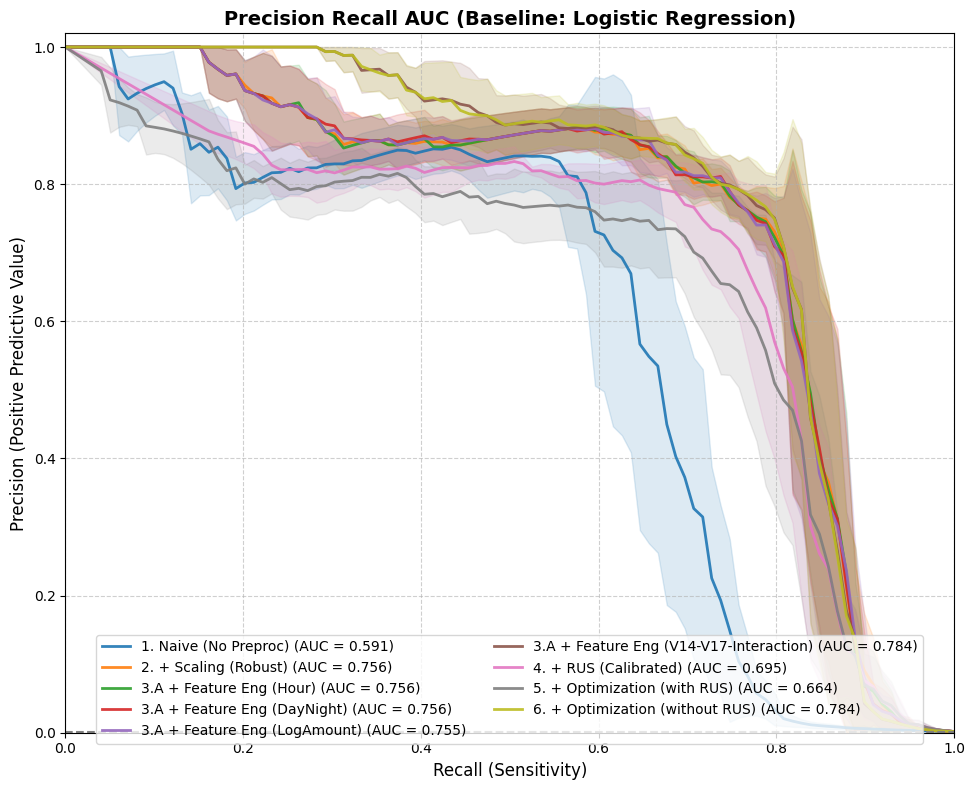

In [ ]:
plot_pr_curves_with_std(plot_data, title="Precision Recall AUC (Baseline: Logistic Regression)")

In [ ]:
# We define distinct pipelines to test each component
configs = {
    "1. Naive (No Preproc)": {
        'scale': False, 'fe': False, 'rus': False, 'opt': False
    },
    "2. + Scaling (Robust)": {
        'scale': True, 'fe': False, 'rus': False, 'opt': False
    },
    "3. + Feature Eng (Hour)": {
        'scale': True, 'fe': True, 'rus': False, 'opt': False
    },
    "4. + RUS (Calibrated)": {
        'scale': True, 'fe': True, 'rus': True, 'opt': False
    },
    "5. + Optimization (with RUS)": {
        'scale': True, 'fe': True, 'rus': True, 'opt': True
    },
    "6. + Optimization (without RUS)": {
        'scale': True, 'fe': True, 'rus': False, 'opt': True
    }
}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class FraudFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Comprehensive Feature Engineering for Credit Card Fraud.

    Adds:
    1. Time Features: Hour, Is_Night
    2. Amount Features: Log_Amount, Amount_Decimal
    3. Interaction Features: V14 * V17 (based on EDA correlations)
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Applies transformations to X."""
        X_out = X.copy()

        # --- 1. Time Features ---
        if 'Time' in X_out.columns:
            # Hour (0-23)
            X_out['Hour'] = (X_out['Time'] % 86400) // 3600

            # Is_Night (Binary): 1 if between 22:00 and 06:00
            # Helping trees isolate nocturnal fraud patterns instantly
            X_out['Is_Night'] = (X_out['Hour'] >= 22) | (X_out['Hour'] <= 6)
            X_out['Is_Night'] = X_out['Is_Night'].astype(int)

        # --- 2. Amount Features ---
        if 'Amount' in X_out.columns:
            # Log Amount: Handles the extreme skew of transaction amounts
            # np.log1p avoids log(0) errors
            X_out['Log_Amount'] = np.log1p(X_out['Amount'])

            # Decimal Part: Captures pricing psychology (e.g., 9.99 vs 10.00)
            X_out['Amount_Dec'] = X_out['Amount'] % 1

        # --- 3. Interaction Features (Based on EDA) ---
        # V17 and V14 had the strongest correlations in your EDA.
        # Multiplying them helps trees find the "diagonal" decision boundary.
        if 'V14' in X_out.columns and 'V17' in X_out.columns:
            X_out['V14_V17'] = X_out['V14'] * X_out['V17']

        return X_out

## Section 2E. Implementation of Classifier 2 - XGBOD


In [20]:
# XGBOD is essentially XGBoost + TOS Features
# So we use the same base_clf and params as XGBoost, but add the feature generator

# XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier

# XGBOD - Unsupervised Outlier Detection
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.loda import LODA

# Same XGB params as for XGBoost
#xgb_params = xgb_params

# Setup models for unsupervised outlier detection as stacked ensemble
# The outlier scores are added as new features to the feature space
outlier_detectors_v1 = [
    # 1. Isolation Forests (Varying diversity)
    IForest(n_estimators=50, random_state=42),
    IForest(n_estimators=100, random_state=42),

    # 2. HBOS (Varying granularity)
    HBOS(n_bins=10),  # Rough grid
    HBOS(n_bins=50),  # Fine grid

    # 3. LODA (Varying projection complexity)
    LODA(n_bins=10),
    LODA(n_bins=20)
]
outlier_detectors = [
    # 1. Standard Global View
    IForest(n_estimators=100, random_state=42),

    # 2. SUBSPACE Views (The Fix)
    # Force these trees to only look at 30% of columns.
    # This finds "local" anomalies hidden in specific feature combinations.
    IForest(n_estimators=100, max_features=0.3, random_state=43),
    IForest(n_estimators=100, max_features=0.5, random_state=44),

    # 3. HBOS (Histogram Bins - Very fast)
    HBOS(n_bins=15),
    HBOS(n_bins=50), # Granular view

    # 4. LODA (Projections - Different math than trees)
    LODA(n_bins=20)
]

df_results, plot_data = run_ablation_study(
    experiment_name="XGBOD",
    base_clf=XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1),
      # eval_metric='logloss' - eval metric for learning, logloss (negative log-likelihood, suitable for classification)
    param_dist=xgb_params,
    X=X, y=y, configs=configs,
    outlier_detection=[('tos', TOSGenerator(detectors=outlier_detectors))] # inject the Outlier Scores
)

visualize_results("XGBOD", xgb_params, df_results, plot_data)

--- Starting Experiment: XGBOD ---

2025-12-14 13:27:30 Running Configuration: 1. Naive (No Preproc)
2025-12-14 13:29:23

| Configuration         |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |
|:----------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|
| 1. Naive (No Preproc) |            0.8023 |          0.0334 |     

KeyboardInterrupt: 

=== Ablation Study Results: XGBOD ===

Date: 20251212_231517

--- Hyperparameters ---
scale_pos_weight     : randint range [400, 600)
max_depth            : randint range [3, 6)
learning_rate        : loguniform(0.01, 0.1)
min_child_weight     : randint range [20, 50)
n_estimators         : [150]
gamma                : [0.2]
subsample            : [0.7]
colsample_bytree     : [0.7]

--- Metrics ---

| Configuration                               |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   colsample_bytree (Mean) |   colsample_bytree (SD) |   gamma (Mean) |   gamma (SD) |   learning_rate (Mean) |   learning_rate (SD) |   max_depth (Mean) |   max_depth (SD) |   min_child_weight (Mean) |   min_child_weight (SD) |   n_estimators (Mean) |   n_estimators (SD) |   scale_pos_weight (Mean) |   scale_pos_weight (SD) |   subsample (Mean) |   subsample (SD) |
|:--------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|--------------------------:|------------------------:|---------------:|-------------:|-----------------------:|---------------------:|-------------------:|-----------------:|--------------------------:|------------------------:|----------------------:|--------------------:|--------------------------:|------------------------:|-------------------:|-----------------:|
| 1. Naive (No Preproc)                       |            0.6494 |          0.3062 |             47.2 |           0.1599 |              24.6 |            0.6757 |          0.3192 |             47.2 |           0.1353 |              20   |          0.6329 |        0.2981 |           47.1 |         0.1752 |            27.7 |             0.725  |           0.344  |              47.4 |            0.0891 |               12.3 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 2. + Scaling (Robust)                       |            0.6468 |          0.2986 |             46.2 |           0.1623 |              25.1 |            0.6794 |          0.3142 |             46.3 |           0.1314 |              19.3 |          0.6269 |        0.2891 |           46.1 |         0.1812 |            28.9 |             0.742  |           0.345  |              46.5 |            0.0715 |                9.6 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.1 + Feature Eng (Hour)                    |            0.8038 |          0.0268 |              3.3 |           0.1895 |              23.6 |            0.8346 |          0.0265 |              3.2 |           0.1596 |              19.1 |          0.7846 |        0.0272 |            3.5 |         0.2083 |            26.5 |             0.8915 |           0.0279 |               3.1 |            0.1039 |               11.7 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.2 + Feature Eng (DayNight)                |            0.7947 |          0.0298 |              3.8 |           0.2026 |              25.5 |            0.8379 |          0.0226 |              2.7 |           0.1591 |              19   |          0.7684 |        0.0346 |            4.5 |         0.229  |            29.8 |             0.9224 |           0.021  |               2.3 |            0.0741 |                8   |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.3 + Feature Eng (LogAmount)               |            0.6509 |          0.3102 |             47.7 |           0.1582 |              24.3 |            0.6798 |          0.3237 |             47.6 |           0.13   |              19.1 |          0.633  |        0.3019 |           47.7 |         0.1757 |            27.7 |             0.7342 |           0.3491 |              47.6 |            0.0767 |               10.5 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 3.4 + Feature Eng (V14-V17-Interaction)     |            0.7987 |          0.0282 |              3.5 |           0.1919 |              24   |            0.828  |          0.0336 |              4.1 |           0.1654 |              20   |          0.7805 |        0.027  |            3.5 |         0.2084 |            26.7 |             0.8827 |           0.0508 |               5.8 |            0.1152 |               13.1 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 4. + RUS (Calibrated)                       |            0.7533 |          0.0493 |              6.5 |           0.0177 |               2.3 |            0.7204 |          0.0936 |             13   |           0.021  |               2.9 |          0.7825 |        0.0186 |            2.4 |         0.0162 |             2.1 |             0.6828 |           0.1443 |              21.1 |            0.0279 |                4.1 |                     nan   |                     nan |          nan   |          nan |               nan      |             nan      |                nan |              nan |                     nan   |                nan      |                   nan |                 nan |                     nan   |                nan      |              nan   |              nan |
| 5.A Optimization (Scaling + FE + RUS)       |            0.6133 |          0.0556 |              9.1 |          -0.0005 |              -0.1 |            0.4456 |          0.0606 |             13.6 |          -0.004  |              -0.9 |          0.8231 |        0.033  |            4   |         0.0072 |             0.9 |             0.307  |           0.054  |              17.6 |           -0.005  |               -1.6 |                       0.7 |                       0 |            0.2 |            0 |                 0.0334 |               0.0002 |                  3 |                0 |                      36.6 |                  1.3416 |                   150 |                   0 |                     468.8 |                 24.1495 |                0.7 |                0 |
| 5.B Optimization (Scaling + FE)             |            0.8124 |          0.0148 |              1.8 |           0.1201 |              14.8 |            0.7533 |          0.0181 |              2.4 |           0.0935 |              12.4 |          0.8577 |        0.0215 |            2.5 |         0.1423 |            16.6 |             0.6726 |           0.0304 |               4.5 |            0.0619 |                9.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0845 |               0      |                  5 |                0 |                      35   |                  0      |                   150 |                   0 |                     414   |                  0      |                0.7 |                0 |
| 5.C Optimization (Scaling + FE (only Hour)) |            0.8097 |          0.0229 |              2.8 |           0.122  |              15.1 |            0.7498 |          0.0287 |              3.8 |           0.0953 |              12.7 |          0.8557 |        0.0236 |            2.8 |         0.1443 |            16.9 |             0.6682 |           0.0393 |               5.9 |            0.0635 |                9.5 |                       0.7 |                       0 |            0.2 |            0 |                 0.0845 |               0      |                  5 |                0 |                      35   |                  0      |                   150 |                   0 |                     414   |                  0      |                0.7 |                0 |

Text report saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_231517_XGBOD_report.txt


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_231517_XGBOD_plot.png

=== Ablation Study Results: XGBOD ===

Date: 20251212_015911

--- Hyperparameters ---
```
scale_pos_weight     : randint range [300, 600)
max_depth            : randint range [3, 6)
learning_rate        : loguniform(0.01, 0.1)
min_child_weight     : [5, 20]
n_estimators         : [150]
gamma                : [0.2]
subsample            : [0.7]
colsample_bytree     : [0.7]
```



--- Metrics ---

| Configuration                               |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   colsample_bytree (Mean) |   colsample_bytree (SD) |   gamma (Mean) |   gamma (SD) |   learning_rate (Mean) |   learning_rate (SD) |   max_depth (Mean) |   max_depth (SD) |   min_child_weight (Mean) |   min_child_weight (SD) |   n_estimators (Mean) |   n_estimators (SD) |   scale_pos_weight (Mean) |   scale_pos_weight (SD) |   subsample (Mean) |   subsample (SD) |
|:--------------------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|------------------:|------------------:|-------------------:|--------------------------:|------------------------:|---------------:|-------------:|-----------------------:|---------------------:|-------------------:|-----------------:|--------------------------:|------------------------:|----------------------:|--------------------:|--------------------------:|------------------------:|-------------------:|-----------------:|
| 1. Naive (No Preproc)                       |            0.8059 |          0.0208 |              2.6 |           0.1896 |              23.5 |            0.8403 |          0.0266 |              3.2 |           0.1554 |              18.5 |          0.7845 |        0.0179 |            2.3 |         0.2109 |            26.9 |             0.905  |           0.04   |               4.4 |            0.0909 |               10   |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 2. + Scaling (Robust)                       |            0.8022 |          0.0193 |              2.4 |           0.1938 |              24.2 |            0.8409 |          0.0216 |              2.6 |           0.1553 |              18.5 |          0.7784 |        0.0195 |            2.5 |         0.2176 |            27.9 |             0.915  |           0.0336 |               3.7 |            0.0815 |                8.9 |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 3.1 + Feature Eng (Hour)                    |            0.7974 |          0.0177 |              2.2 |           0.1977 |              24.8 |            0.8347 |          0.021  |              2.5 |           0.1607 |              19.3 |          0.7744 |        0.0161 |            2.1 |         0.2205 |            28.5 |             0.9054 |           0.0295 |               3.3 |            0.0905 |               10   |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 3.2 + Feature Eng (DayNight)                |            0.8    |          0.0258 |              3.2 |           0.1968 |              24.6 |            0.8384 |          0.0213 |              2.5 |           0.159  |              19   |          0.7764 |        0.0295 |            3.8 |         0.22   |            28.3 |             0.9122 |           0.0248 |               2.7 |            0.0863 |                9.5 |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 3.3 + Feature Eng (LogAmount)               |            0.7943 |          0.0271 |              3.4 |           0.2035 |              25.6 |            0.837  |          0.0241 |              2.9 |           0.1607 |              19.2 |          0.7683 |        0.029  |            3.8 |         0.2297 |            29.9 |             0.9196 |           0.0216 |               2.4 |            0.0779 |                8.5 |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 3.4 + Feature Eng (V14-V17-Interaction)     |            0.7836 |          0.0302 |              3.8 |           0.201  |              25.7 |            0.8151 |          0.0321 |              3.9 |           0.1724 |              21.1 |          0.7643 |        0.0337 |            4.4 |         0.2184 |            28.6 |             0.8762 |           0.0578 |               6.6 |            0.1161 |               13.2 |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 4. + RUS (Calibrated)                       |            0.7566 |          0.0508 |              6.7 |           0.0245 |               3.2 |            0.7231 |          0.0874 |             12.1 |           0.0253 |               3.5 |          0.7845 |        0.0258 |            3.3 |         0.025  |             3.2 |             0.6814 |           0.1307 |              19.2 |            0.0285 |                4.2 |                     nan   |                     nan |          nan   |          nan |               nan      |                  nan |                nan |              nan |                       nan |                     nan |                   nan |                 nan |                       nan |                     nan |              nan   |              nan |
| 5.A Optimization (Scaling + FE + RUS)       |            0.7533 |          0.0413 |              5.5 |          -0.0038 |              -0.5 |            0.7419 |          0.0727 |              9.8 |          -0.0061 |              -0.8 |          0.7642 |        0.0323 |            4.2 |        -0.0014 |            -0.2 |             0.7323 |           0.1197 |              16.3 |           -0.0085 |               -1.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0297 |                    0 |                  3 |                0 |                         5 |                       0 |                   150 |                   0 |                       430 |                       0 |                0.7 |                0 |
| 5.B Optimization (Scaling + FE)             |            0.8211 |          0.0194 |              2.4 |           0.1206 |              14.7 |            0.7692 |          0.0206 |              2.7 |           0.0966 |              12.6 |          0.8597 |        0.0198 |            2.3 |         0.1403 |            16.3 |             0.6962 |           0.0239 |               3.4 |            0.0673 |                9.7 |                       0.7 |                       0 |            0.2 |            0 |                 0.0724 |                    0 |                  5 |                0 |                         5 |                       0 |                   150 |                   0 |                       466 |                       0 |                0.7 |                0 |
| 5.C Optimization (Scaling + FE (only Hour)) |            0.8178 |          0.0198 |              2.4 |           0.1226 |              15   |            0.767  |          0.0213 |              2.8 |           0.0962 |              12.5 |          0.8557 |        0.0197 |            2.3 |         0.1443 |            16.9 |             0.6952 |           0.0246 |               3.5 |            0.0642 |                9.2 |                       0.7 |                       0 |            0.2 |            0 |                 0.0724 |                    0 |                  5 |                0 |                         5 |                       0 |                   150 |                   0 |                       466 |                       0 |                0.7 |                0 |

Text report saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_015911_XGBOD_report.txt


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251212_015911_XGBOD_plot.png
